In [2]:
import numpy as np
import tensorflow as tf # gives warning from h5py but it is fine.
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import display, clear_output as clc
import sys
import pandas as pd

def stats(data, others=dict()):
    if not isinstance(data, pd.DataFrame):
        data = data.to_frame()
    stats = pd.concat([data.nunique(), data.dtypes, data.isnull().sum()], axis=1)
    stats.columns = ['Unique', 'Dtypes', 'NaN Count']
    for k,v in others.items():
        stats[k] = v(data)
    return stats

def page(data, wrap_cols=14):
    if not isinstance(data, pd.DataFrame):
        data = data.to_frame().T
    for i in range(wrap_cols, data.shape[1]+wrap_cols, wrap_cols):
        print ('Columns', i-wrap_cols, '-', min(i-1,data.shape[1]-1))
        display(data.iloc[:, i-wrap_cols:i])

C:\Users\spenc\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
tf.__version__

'1.7.0'

In [4]:
# Import dataset
D0 = pd.read_csv ('train_final.csv', index_col=0)
D0.head ()

,Y,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27
id,,,,,,,,,,,,,,,,,,,,,
1,0,1,0,0.107576,0,0.0,1,1,1,1,...,104,22902.0,1,0,18,0.042295,1,0,27,0.028250
2,0,1,0,0.142357,0,0.0,7,1,1,1,...,144,11400.0,1,0,8,0.021417,1,0,67,0.253574
3,0,1,0,0.492318,0,3.0,4205,1,1,3,...,112,4833.0,1,0,13,0.502212,1,1,35,0.373397
4,0,1,0,-0.053028,0,2.0,2,1,1,5,...,127,3250.0,1,1,8,0.000000,1,0,50,0.674254
5,0,1,0,0.730797,0,0.0,11,1,1,1,...,148,4000.0,1,1,5,0.787592,1,0,71,0.371157


In [5]:
# Count number unique values and NaNs
page (D0.nunique ().T)
page (D0.isnull ().sum ())

Columns 0 - 13


,Y,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13
0,2,9,12,49998,9,11,1880,9,9,322,23,43,9,10


Columns 14 - 27


,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27
0,16,10,310,9,83,8770,10,334,55,42562,9,14,83,41705


Columns 0 - 13


,Y,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13
0,0,0,0,0,0,1268,0,0,0,0,0,0,0,0


Columns 14 - 27


,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27
0,0,0,0,0,0,9828,0,0,0,0,0,0,0,0


In [6]:
# Fill NaNs to get new dataframe D1
D1 = D0.fillna (method='ffill')

# Confirm no NaNs
page (D1.isnull ().sum ())

Columns 0 - 13


,Y,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Columns 14 - 27


,F14,F15,F16,F17,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
# Compare value counts of filled column
page (D0.iloc[:,5].value_counts ())
page (D1.iloc[:,5].value_counts ())

Columns 0 - 10


,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
F5,29110,8682,6516,3129,977,232,55,18,8,2,1


Columns 0 - 10


,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
F5,29863,8904,6701,3202,1002,242,55,18,8,2,1


In [8]:
# Decide feature types (categorical/continuous) based on number of unique values
continuous_cols = [3, 6, 9, 16, 19, 21, 23, 27]
categorical_cols = list (set (range (1, 28)) - set (continuous_cols))
continuous_cols, categorical_cols

([3, 6, 9, 16, 19, 21, 23, 27],
 [1, 2, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 17, 18, 20, 22, 24, 25, 26])

In [9]:
# View data types of categorical columns
page (D1.iloc[:,categorical_cols].dtypes)
page (D1['F5'].value_counts ())

Columns 0 - 13


,F1,F2,F4,F5,F7,F8,F10,F11,F12,F13,F14,F15,F17,F18
0,int64,int64,int64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


Columns 14 - 18


,F20,F22,F24,F25,F26
0,int64,int64,int64,int64,int64


Columns 0 - 10


,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0
F5,29863,8904,6701,3202,1002,242,55,18,8,2,1


In [10]:
# Convert F5 to int to meet tf.feature_column data type requirement
D2 = D1.copy ()
D2['F5'] = D1['F5'].astype ('int')
page (D2['F5'].value_counts ())

Columns 0 - 10


,0,1,2,3,4,5,6,7,8,9,10
F5,29863,8904,6701,3202,1002,242,55,18,8,2,1


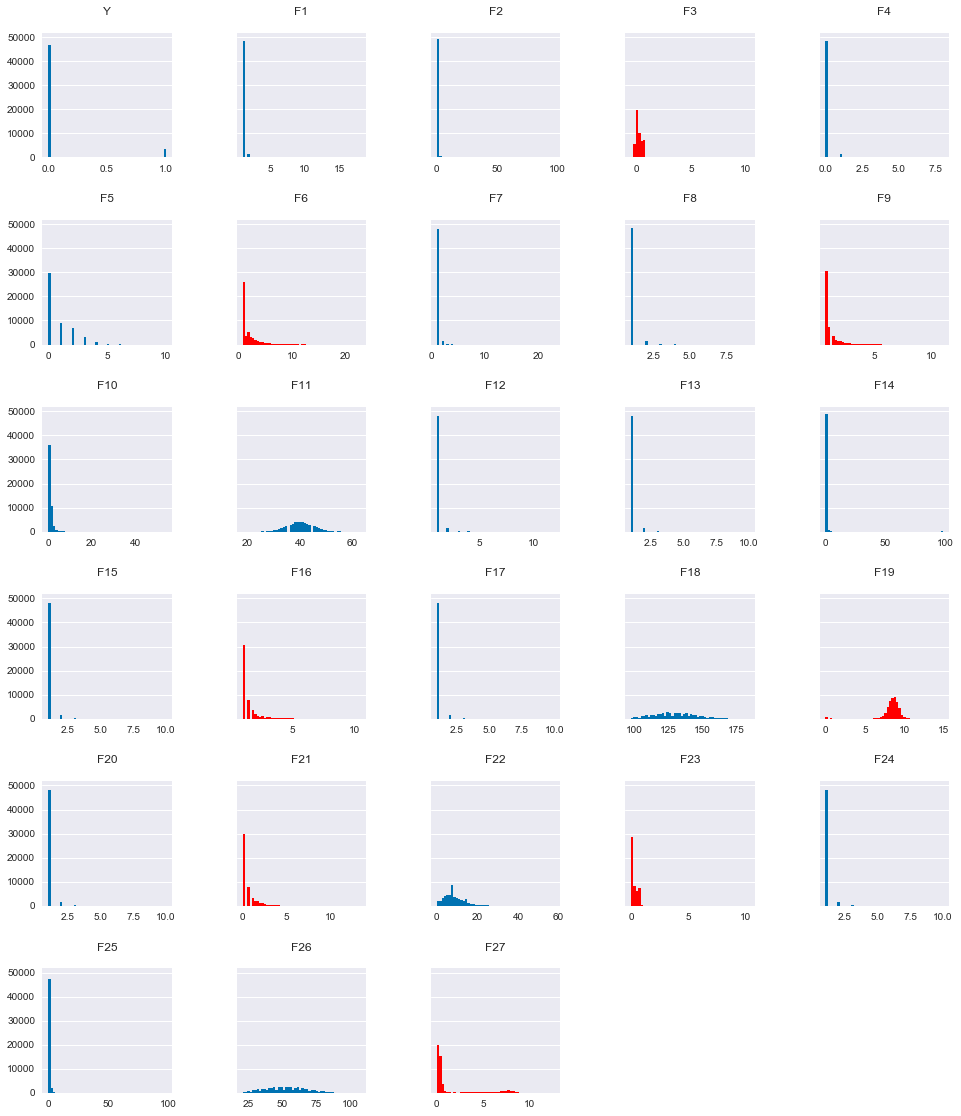

In [11]:
# Plot feature histograms

import math

# Set subplots layout
cols = 5
rows = math.ceil (D2.shape[1]/cols)
fig, ax = plt.subplots (rows, cols, figsize=(3.25*cols,3.25*rows), sharey=True)
plt.subplots_adjust (hspace=.5, wspace=.5)

# Plot histograms
for i, (a, col) in enumerate (zip (ax.flat, D2)):
    plt.sca (a)
    if D2[col].nunique () > 100:
        plt.hist (np.log1p (D2[col]), bins=50, color='r')
    else:
        plt.hist (D2[col], bins=50)
    plt.grid (axis='x')
    plt.title (col + '\n')

# Clip unused axes
for a in ax.flat[D2.shape[1]:]:
    plt.delaxes (a)

Conv1D shape analysis
---

`kernel size` refers to receptive field of kernel (the width of a kernel of 2 elements but power-of-two dilation).

Dilation changes the effective kernel size by:

$$\text{kernel_size} = \text{kernel_size} + (\text{kernel_size} - 1) * (\text{dilation} - 1)$$

| dilation rate | kernel_size |
| :-----------: | :---------: |
|       1       |      2      |
|       2       |      3      |
|       4       |      5      |
|       8       |      9      |
|      16       |     17      |
|      32       |     33      |

When $\text{dilation} = 2^{k-1}$ at layer $k$ and $\text{kernel_size} = 2$:

$$\text{kernel_size} = (2) + (2 - 1) * (2^{k-1} - 1) = 2^{k-1} + 1$$

`output width` refers to the width of the output with 'valid' padding


| kernel size | output width |
| :---------: | :----------: |
|     2       |        3     |
|     3       |        1     |


| kernel size | output width |
| :---------: | :----------: |
|     2       |        7     |
|     3       |        5     |
|     5       |        1     |


| kernel size | output width |
| :---------: | :----------: |
|     2       |       15     |
|     3       |       13     |
|     5       |        9     |
|     9       |        1     |


After $k$ layers, output dims is trimmed in width by $2^{k}-1$.

If $N = 2^{k}$, then output dims is reduced to $1$ after $k$ layers.

# EDIT: Actually just use valid padding
For $N=8$, this picture shows which outputs are actually used with valid padding. Many are wasted.
Same padding would make use of these unused outputs and is no worse than any other substitute estimate for the later samples in an input block.

`
[.][.][.][.][.][.][.][.]  input
[.] . [.] . [.] . [.]     layer 1 output
[.] .  .  . [.]           layer 2 output
[.]                       layer 3 output`

In [ ]:
tf.InteractiveSession ()

In [ ]:
# Scratch area: Just testing
a = tf.convert_to_tensor (np.r_['0,2',[0,0,0,4],[4,0,0,8],[8,0,0,12],[12,0,0,16]])
# tf.cast (a > 0, tf.double) * a
# a[1::2],a

b = tf.zeros ([4,4])
b = a
a *= 3
b += b
b.eval (), a.eval ()


In [ ]:
c = tf.Variable (tf.constant (.5, shape=[4,1]))
tf.get_default_session ().run (tf.global_variables_initializer ())
print (a.eval ())
d = tf.concat ([tf.cast (a, tf.float32), c], axis=-1)
e = c * 200
with tf.control_dependencies ([e]):
    print (d.eval ())

In [ ]:
f = tf.zeros ([2,4,2,3])
f = tf.expand_dims (f, axis=-4)
f.eval (), f.shape

In [ ]:
a = np.r_[0:4]
b = np.zeros ([4])
b = a[:]
a *= 2
b, a

In [ ]:
a = np.r_[5,2,6,3,7]
f = np.r_[range (5)]
random.shuffle (f)
g = np.argsort (a[f])
a[f[g]]

# Hypothesis

Prediction on many input samples (specifically on input blocks of size &lt;PARAMS.width&gt;) which are sorted in order of their predicted likelihood provides a stronger inductive bias for improving the AUC loss.

A convolutional hierarchical structure will hopefully "compare" samples in an input block as it is forming a likelihood estimate.

In [12]:
# Configure model parameters

class PARAMS:
    k = 6
    width = 2**(k)
    batch_size = 64
    computed_batch_size = batch_size + width - 1
    kernel_size = 2
    depth = k
    output_channels = 256
    projection_channels = 64
    num_refinements = 3

In [13]:
# Set up input pipeline

# Imports
categorical_column_with_vocabulary_list = tf.feature_column.categorical_column_with_vocabulary_list
embedding_column = tf.feature_column.embedding_column
numeric_column = tf.feature_column.numeric_column


# Training input function feeds from dataframe D2
train_fn = tf.estimator.inputs.pandas_input_fn (
    D2.iloc[:,1:],
    y=D2['Y'],
    batch_size=PARAMS.computed_batch_size,
#     queue_capacity=10 * PARAMS.computed_batch_size,
    num_epochs=None,
    shuffle=True,
    num_threads=1,
    target_column='Y'
)


# Preprocess features according to type:
# Make embeddings for categorical features
categorical = []

for col_idx in categorical_cols:
    name = D2.columns[col_idx]
    unique = D2.iloc[:,col_idx].unique ()
    column = categorical_column_with_vocabulary_list (
        key=name,
        vocabulary_list=unique
    )
    embedded = embedding_column (column, math.ceil (math.log2 (len (unique))))
    categorical.append (embedded)
    
    
# No preprocessing for continuous features
continuous = [numeric_column (D2.columns[col_idx]) for col_idx in continuous_cols]

In [14]:
# Build model

# Imports
Estimator = tf.estimator
batch_normalization = tf.layers.batch_normalization
Conv1D = tf.layers.Conv1D
input_layer = tf.feature_column.input_layer
import math
from functools import reduce
from itertools import chain


# Model definition
def model_fn (features, labels, mode, params):
    
    # (Step 0)
    # Identify run mode
    TRAIN, EVAL, PREDICT = [mode == getattr (Estimator.ModeKeys, e) for e in ['TRAIN', 'EVAL', 'PREDICT']]
        
        
    # (Step 1)
    # Make input layer of all features, shape: (PARAMS.computed_batch_size, len (features))
    inputs = input_layer (features, params['feature_columns'])
    
    # Normalize inputs
    inputs = batch_normalization (inputs, training=TRAIN)
    
    # Inform tensorflow of the batch size
    inputs.set_shape ([PARAMS.computed_batch_size, None])
    
    # Save before the next step (will reuse the current state of inputs)
    save_inputs = inputs
    
    # Initialize a column for prior estimates
    prior_estimates = tf.constant (params['P(Y=1)'], shape=[inputs.shape[0], 1])
    inputs = tf.concat ([inputs, prior_estimates], axis=-1)
    

    # (Step 2)
    # Configure convolutional layers
    # Each layer module contains a pair <projection, layer> to be applied
    # together in a residual block.
    # First layer module doesn't have a projection.
    
    first_layer = [
        None,
        Conv1D (
            filters=PARAMS.output_channels,
            kernel_size=PARAMS.kernel_size,
            padding='same',
            name='Conv1D_First_Layer'
        )
    ]
    
    layers = [
        [
            Conv1D (
                filters=PARAMS.projection_channels,
                kernel_size=1,
                activation=tf.nn.leaky_relu,
                name='Conv1D_{}_Projection'.format (i)
            ),
            Conv1D (
                filters=PARAMS.output_channels,
                kernel_size=PARAMS.kernel_size,
                padding='same',
                dilation_rate=2**i,
                name='Conv1D_{}_Dilation_{}'.format (i, 2**i)
            )
        ]
        for i in range (1, PARAMS.depth)
    ]
    
    final_layer = [
        Conv1D (
            filters=PARAMS.projection_channels,
            kernel_size=1,
            activation=tf.nn.leaky_relu,
            name='Final_Layer_Projection'
        ),
        Conv1D (
            filters=2,
            kernel_size=1,
            name='Final_Layer'
        )
    ]
    
    # Attach dilation_rate to layer
    for i, (_, layer) in enumerate (layers, 1):
        layer.__dilation_rate = 2**i
    
    first_layer[1].__dilation_rate = 1
    final_layer[1].__dilation_rate = 1
    
    # Count and report number of parameters
    layer_params_count = 0
    for _, layer in [first_layer] + layers + [final_layer]:
        count = layer.count_params ()
        print ('Layer {} Usage: {} params, {} KB'.format (layer.name, count, count * 4 / 1024))
        layer_params_count += count
    print ('Total Usage: {} params, {} MB'.format (layer_params_count, layer_params_count * 4 / 1024 / 1024))
    

    # Step (3)
    # Define residual connection block with batch normalization and relu activation
    layer_histogram_flag = False
    def connect (inputs, layer_module, residual=True, activation=tf.nn.leaky_relu):
        print ('Apply layer: {}...'.format (layer_module[1].name))
        
        # Apply projection if exists
        projection, layer = layer_module
        if projection is not None:
            result = projection (inputs)
        else:
            result = inputs
            
        # Calculate required padding if using dilated convolution
        if layer.__dilation_rate > 1:
            required_padding, crops = tf.required_space_to_batch_paddings (result.shape, [1, 2, 1])
            result = tf.pad (result, required_padding)
            
        # Apply main convolution
        result = layer (result)
        
        # Trim required padding if used
        if layer.__dilation_rate > 1:
            result = tf.slice (
                result,
                begin=required_padding[:, 0],
                size=inputs.shape
            )
        
        # Apply residual shortcut
        if residual:
            # Apply batch normalization here too (?)
#             result = batch_normalization (result, training=TRAIN)
            result += inputs
        
        # Apply batch normalize and activation
        result = batch_normalization (result, training=TRAIN)
        if activation:
            result = activation (result)
        
        # Visualize layer outputs
        if layer_histogram_flag:
            tf.summary.histogram ('Report_' + layer.name + '_Activations', result)
        
        return result
    
    # Define helper function to run layers
    def apply_to (inputs):
        result = reduce (
            connect,
            layers,
            connect (inputs, first_layer, residual=False)
        )
        result = connect (result, final_layer, residual=False, activation=None)
        
        return result
    
    
    # Step (4)
    # Obtain first-pass estimates on the output for each row of the inputs
    def first_pass (input_row):
        # Tile input row to full width (PARAMS.width)
        input_row = tf.reshape (input_row, [1, 1, -1])
        tiled_row = tf.tile (input_row, [1, PARAMS.width, 1])
        
        # Evaluate network on tiled row and average results
        result = apply_to (tiled_row)
        result = tf.squeeze (result)
        result = tf.nn.softmax (result)[:, 1]
        mean = tf.reduce_mean (result)
        stddev = tf.reduce_mean (tf.squared_difference (result, mean))**0.5
        
        return mean, stddev
    
    # Evaluate first_pass() on each row of the batch
    first_pass_estimates, first_pass_stddev = tf.map_fn (
        first_pass,
        inputs,
        dtype=(inputs.dtype, inputs.dtype),
        name='First_Pass_Estimates'
    )
    
    # Visualize first pass outputs
    tf.summary.histogram ('Report_First_Pass_Estimates', first_pass_estimates)
    tf.summary.histogram ('Report_First_Pass_Standard_Deviation', first_pass_stddev)
    
    
    # Step (5)
    # Sort inputs by first-pass estimates
    
    # Define helper function to repeat this step's functionality
    # Expects estimates to be probabilities (logits after softmax is applied)
    # Expects estimates to be rank 1.
    def update_prior_estimates_and_get_sorted_indices (estimates):    
        nonlocal inputs, prior_estimates
        # Note: nonlocal allows assigning directly to these variables
        # instead of using a return value
        
        prior_estimates = estimates
        inputs = tf.concat ([save_inputs, tf.expand_dims (prior_estimates, axis=-1)], axis=-1)
        _, sorted_indices = tf.nn.top_k (
            estimates,
            k=inputs.shape[0],
            name='Sort_By_First_Pass_Estimates'
        )
        
        return sorted_indices
    
    sorted_indices = update_prior_estimates_and_get_sorted_indices (first_pass_estimates)
    
    
    # Step (6)
    # Repeatedly make predictions and sort inputs based on these prediction values
    # Hopefully this will "refine" the predictions
    
    for i in range (PARAMS.num_refinements):
        print ('Refinement round {}...'.format (i))
        
        # Run model on sorted inputs
        prepared_inputs = tf.gather (inputs, sorted_indices)
        prepared_inputs = tf.expand_dims (prepared_inputs, 0)
        layer_histogram_flag = True
        result = apply_to (prepared_inputs)
        result = tf.squeeze (result)
        
        # Record predictions (in terms of original inputs order)
        inverse_indices = tf.invert_permutation (sorted_indices)
        predictions = tf.gather (result, inverse_indices, name='Predictions_{}'.format (i))
        
        # Use a "refinement loss" which hopefully improves self-consistency during refinement process.
        if not PREDICT:
            refinement_loss = tf.nn.softmax_cross_entropy_with_logits_v2 (
                labels=tf.nn.softmax (predictions),
                logits=tf.stack ([1 - prior_estimates, prior_estimates], axis=-1)
            )
            refinement_loss = tf.reduce_mean (refinement_loss, name='Refinement_Loss_{}'.format (i))
            
            # Log and visualize refinement loss
            tf.summary.scalar ('Report_Refinement_Loss_{}'.format (i), refinement_loss)
            
            if TRAIN and 0:
                refinement_optimizer = tf.train.AdamOptimizer ()
                
                # Visualize refinement gradients
                refinement_gv_pairs = refinement_optimizer.compute_gradients (refinement_loss)
                tf.summary.histogram ('Report_Refinement_Gradients_{}'.format (i), [g for (g,v) in refinement_gv_pairs])
                refinement_optimizer.apply_gradients (refinement_gv_pairs)
        
        # Get new sorted indices to prepare to repeat
        probabilities = tf.nn.softmax (predictions, name='Probabilities_{}'.format (i))[:, 1]
        new_indices = update_prior_estimates_and_get_sorted_indices (probabilities)
        sorted_indices = tf.gather (sorted_indices, new_indices)
        
    
    # Step (7)
    # Output predictions
    avg_probability = tf.reduce_mean (probabilities, name='Avg_Probability')
    tf.summary.histogram ('Report_Probabilities', probabilities)
    
    if PREDICT:
        output = {
            'probabilities': probabilities
        }
        return Estimator.EstimatorSpec (mode=mode, predictions=output)


    # Step (8)
    # Define loss and metrics
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits (
        labels=labels,
        logits=predictions
    )
    cross_entropy = tf.reduce_mean (cross_entropy, name='Cross_Entropy')
    
    auc = tf.metrics.auc (
        labels=labels,
        predictions=probabilities,
        name='AUC'
    )
    
    accuracy = tf.metrics.accuracy (
        labels=labels,
        predictions=tf.round (probabilities),
        name='Accuracy'
    )
    
    metrics = {
        'AUC': auc,
        'Accuracy': accuracy,
    }
    
    
    # Step (9)
    # Report metrics
    if EVAL:
        return Estimator.EstimatorSpec (mode=mode, loss=cross_entropy, eval_metric_ops=metrics)
    
    # Reset metrics per batch, update, and calculate
    auc_vars = tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, scope="AUC")
    accuracy_vars = tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, scope="Accuracy")
    reset_metric_vars = tf.variables_initializer(var_list=auc_vars + accuracy_vars)
    with tf.control_dependencies ([reset_metric_vars]):
        with tf.control_dependencies ([auc[1]]):
            auc = tf.identity (auc[0], name='AUC_value')
        with tf.control_dependencies ([accuracy[1]]):
            accuracy = tf.identity (accuracy[0], name='Accuracy_value')
    
    # Step (9)
    # Optimize loss
    if TRAIN:
        optimizer = tf.train.AdamOptimizer (learning_rate=.01)
        with tf.control_dependencies ([auc, accuracy]):
            train_op = optimizer.minimize (cross_entropy, global_step=tf.train.get_global_step())
            
        return Estimator.EstimatorSpec (mode=mode, loss=cross_entropy, train_op=train_op)


In [35]:
# Train model

# Set custom run configuration
config = tf.estimator.RunConfig (
    save_summary_steps=50,
    session_config=tf.ConfigProto (
        gpu_options={
#             'allow_growth': True,
#             'per_process_gpu_memory_fraction': 0.9
        },
        graph_options={
#             'build_cost_model': 0 # Try this?
        }
    )
)


# Instantiate from model_fn
variant = 'lr=.01,refine=False,batch=127,class_weight=True'
class_one_probability = sum (D2['Y'] == 1) / len (D2)
model = Estimator.Estimator (
    model_fn,
    model_dir='model_dir' + '/' + variant,
    params={
        'feature_columns': categorical + continuous,
        'P(Y=1)': class_one_probability
    },
    config=config
)


# List tensors to be logged
tensors_to_log = {
    'AUC': 'AUC_value',
    'Cross Entropy': 'Cross_Entropy',
    'Accuracy': 'Accuracy_value',
    'Refinement Loss': 'Refinement_Loss_{}'.format (PARAMS.num_refinements - 1),
    'Avg Probability': 'Avg_Probability'
}
hook = tf.train.LoggingTensorHook (tensors=tensors_to_log, every_n_iter=10)


# Train
batch_count = len (D2)//PARAMS.computed_batch_size
print ('Batch count: {}'.format (batch_count))
model.train (input_fn=train_fn, hooks=[hook], steps=batch_count)

INFO:tensorflow:Using config: {'_model_dir': 'model_checkpoint', '_tf_random_seed': None, '_save_summary_steps': 50, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': gpu_options {
}
graph_options {
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000022DCBEE2588>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Batch count: 393
INFO:tensorflow:Calling model_fn.
Apply layer: Conv1D_First_Layer...
Apply layer: Conv1D_1_Dilation_2...
Apply layer: Conv1D_2_Dilation_4...
Apply layer: Conv1D_3_Dilation_8...
Apply layer: Conv1D_4_Dilation_16...
Apply layer: Conv1D_5_Dilation_32...
Apply layer: Final_Layer...
Refinement round 0...
Apply layer: Conv1D_First_Layer...
Apply layer: Conv1D

INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.26231265, Accuracy = 0.0, Refinement Loss = 1.0583384, Avg Probability = 0.08352577 (0.780 sec)
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.16677877, Accuracy = 0.0, Refinement Loss = 1.0731038, Avg Probability = 0.07861919 (0.769 sec)
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.22912787, Accuracy = 0.0, Refinement Loss = 1.0907776, Avg Probability = 0.08083107 (0.772 sec)
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.17271015, Accuracy = 0.0, Refinement Loss = 1.0385149, Avg Probability = 0.0829068 (0.779 sec)
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.16121484, Accuracy = 0.0, Refinement Loss = 1.0663723, Avg Probability = 0.080745764 (0.779 sec)
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.098693505, Accuracy = 0.0, Refinement Loss = 1.0669965, Avg Probability = 0.08326852 (0.781 sec)
INFO:tensorflow:Saving checkpoints for 3992 into model_checkpoint\model.ckpt.
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.16523439, Accuracy = 0.0, Refi

INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.14671119, Accuracy = 0.0, Refinement Loss = 1.0997473, Avg Probability = 0.07570366 (0.805 sec)
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.21257286, Accuracy = 0.0, Refinement Loss = 1.1165365, Avg Probability = 0.069259286 (0.792 sec)
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.11322095, Accuracy = 0.0, Refinement Loss = 1.083321, Avg Probability = 0.07725779 (0.807 sec)
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.20604874, Accuracy = 0.0, Refinement Loss = 1.1279105, Avg Probability = 0.074356124 (0.804 sec)
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.13722377, Accuracy = 0.0, Refinement Loss = 1.0465177, Avg Probability = 0.08304586 (0.796 sec)
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.108991295, Accuracy = 0.0, Refinement Loss = 1.1078871, Avg Probability = 0.07376021 (0.800 sec)
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.13880561, Accuracy = 0.0, Refinement Loss = 1.0665556, Avg Probability = 0.07765297 (0.805 sec)
INFO:tensor

INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.1818559, Accuracy = 0.0, Refinement Loss = 1.0923499, Avg Probability = 0.075213045 (0.781 sec)
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.17582744, Accuracy = 0.0, Refinement Loss = 1.0904, Avg Probability = 0.074561544 (0.787 sec)
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.22857903, Accuracy = 0.0, Refinement Loss = 1.1084756, Avg Probability = 0.07306035 (0.801 sec)
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.19821684, Accuracy = 0.0, Refinement Loss = 1.0712388, Avg Probability = 0.077391185 (0.771 sec)
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.201753, Accuracy = 0.0, Refinement Loss = 1.0656916, Avg Probability = 0.07294527 (0.786 sec)
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.14893296, Accuracy = 0.0, Refinement Loss = 1.0902696, Avg Probability = 0.07106864 (0.778 sec)
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.18783405, Accuracy = 0.0, Refinement Loss = 1.0899245, Avg Probability = 0.07455699 (0.806 sec)
INFO:tensorflow:

INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.275488, Accuracy = 0.0, Refinement Loss = 1.0719292, Avg Probability = 0.075863175 (0.791 sec)
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.19815989, Accuracy = 0.0, Refinement Loss = 1.0796301, Avg Probability = 0.074467294 (0.780 sec)
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.27593446, Accuracy = 0.0, Refinement Loss = 1.0815343, Avg Probability = 0.0759079 (0.790 sec)
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.19668302, Accuracy = 0.0, Refinement Loss = 1.0518919, Avg Probability = 0.07664338 (0.767 sec)
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.20005453, Accuracy = 0.0, Refinement Loss = 1.113242, Avg Probability = 0.070231356 (0.803 sec)
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.15606993, Accuracy = 0.0, Refinement Loss = 1.0968425, Avg Probability = 0.06838752 (0.800 sec)
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.13197337, Accuracy = 0.0, Refinement Loss = 1.0999498, Avg Probability = 0.070353776 (0.769 sec)
INFO:tensorfl

INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.11733534, Accuracy = 0.0, Refinement Loss = 1.1080012, Avg Probability = 0.06681976 (0.772 sec)
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.14808255, Accuracy = 0.0, Refinement Loss = 1.1016605, Avg Probability = 0.07089543 (0.783 sec)
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.18992747, Accuracy = 0.0, Refinement Loss = 1.0931044, Avg Probability = 0.070250474 (0.774 sec)
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.2102666, Accuracy = 0.0, Refinement Loss = 1.1072308, Avg Probability = 0.07394349 (0.810 sec)
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.20923229, Accuracy = 0.0, Refinement Loss = 1.1024381, Avg Probability = 0.07595906 (0.820 sec)
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.26277557, Accuracy = 0.0, Refinement Loss = 1.1128294, Avg Probability = 0.07287167 (0.771 sec)
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.14991973, Accuracy = 0.0, Refinement Loss = 1.095464, Avg Probability = 0.07173039 (0.780 sec)
INFO:tensorflo

INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.16374168, Accuracy = 0.0, Refinement Loss = 1.073896, Avg Probability = 0.07589324 (0.799 sec)
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.20397022, Accuracy = 0.0, Refinement Loss = 1.0530394, Avg Probability = 0.07639847 (0.801 sec)
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.28674483, Accuracy = 0.0, Refinement Loss = 1.0939881, Avg Probability = 0.074457474 (0.771 sec)
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.2633331, Accuracy = 0.0, Refinement Loss = 1.08281, Avg Probability = 0.07406304 (0.795 sec)
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.1750585, Accuracy = 0.0, Refinement Loss = 1.0807207, Avg Probability = 0.0739361 (0.793 sec)
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.12942874, Accuracy = 0.0, Refinement Loss = 1.1366911, Avg Probability = 0.07041185 (0.790 sec)
INFO:tensorflow:AUC = 0.0, Cross Entropy = 0.17174713, Accuracy = 0.0, Refinement Loss = 1.0958747, Avg Probability = 0.072737806 (0.801 sec)
INFO:tensorflow:A

INFO:tensorflow:Loss for final step: 0.3126266.


In [ ]:
# Ask stackoverflow why my 10MB dataset takes over ten minutes on just the first iteration
# Other steps take 8 seconds each
# Batch size is 128
# input_fn uses ...
# I've tried changing some of the ConfigProto settings (reference related github thread) to turn off graph optimization
#  https://github.com/tensorflow/tensorflow/blob/r1.7/tensorflow/core/protobuf/config.proto
# I've tried changing the pre-allocated memory
# Actually not limiting pre-allocation seems to go faster. 380 second initial stall instead of 900 + 600.
# (no pre-alloc finished in 1700sec)
# Device: GTX 1060 GPU with 6GB memory, 7th gen intel i7 CPU with 16GB memory
# nvidia-smi doesn't show how much memory python.exe is using
# model weight count is: ...